In [2]:
import torch

import numpy as np
from scipy.integrate import solve_ivp
import pprint

import torch.nn as nn

from sbi import utils as sbi_utils
from sbi.inference import NPE, simulate_for_sbi
from sbi.analysis import pairplot
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

from sbi.neural_nets import posterior_nn
from sbi.inference import NPE

In [3]:
def multiphase_tank(theta):
    """
    Simplified tank model for multiphase flow.

    theta: [k_P, k_alpha, Q_g, Q_l]
    """
    k_P, k_alpha, Q_g, Q_l = theta
    
    Q_out = 0.05  # fixed known outflow
    P0 = 5e6      # initial pressure (Pa)
    alpha0 = 0.2  # initial gas fraction

    def rhs(t, y):
        P, alpha = y
        
        dP_dt = k_P * (Q_g - alpha * Q_out)
        d_alpha_dt = k_alpha * ((Q_g / (Q_g + Q_l)) - alpha)
        
        return [dP_dt, d_alpha_dt]

    t_span = (0, 200)
    t_eval = np.linspace(*t_span, 200)
    sol = solve_ivp(rhs, t_span, [P0, alpha0], t_eval=t_eval)

    if not sol.success:
        raise RuntimeError("Simulation failed")

    return sol.y.flatten()

In [4]:
def multiphase_tank_summary(theta):
    output = multiphase_tank(theta).flatten()
    P, alpha = output[:200], output[200:]

    def slope(y):
        return (y[-1] - y[0]) / 200
    
    def time_to_equilibrium(y, tol=1e-2):
        for i in range(1, len(y)):
            if np.abs(y[i] - y[-1]) < tol:
                return i
        return len(y)

    stats = np.array([
        np.mean(P), np.std(P), P[-1], slope(P), time_to_equilibrium(P),
        np.mean(alpha), np.std(alpha), alpha[-1], slope(alpha), time_to_equilibrium(alpha),
    ])

    return stats

def multiphase_tank_summary_normalized(theta):
    raw_stats = multiphase_tank_summary(theta)
    normalized_stats = (raw_stats - stats_mean) / stats_std
    return normalized_stats


def multiphase_tank_summary_snapshots(theta):
    output = multiphase_tank(theta).flatten()
    P, alpha = output[:200], output[200:]

    # Choose snapshot time points
    t0, t1, t2, t3, t4, t5 = 1, 20, 50, 100, 150, 199  # early, mid, late

    stats = np.array([
        P[t0], P[t1], P[t2], P[t3], P[t4], P[t5],
        alpha[t0], alpha[t1], alpha[t2],  alpha[t3], alpha[t4], alpha[t5]
    ])

    return stats

def multiphase_tank_for_cnn(theta):
    output = multiphase_tank(theta)  # shape: (400,)
    output = output.reshape(2, 200)  # [channels, time]
    return output.astype(np.float32)

def multiphase_tank_normalized(theta):
    output = multiphase_tank(theta).reshape(2, 200)
    output[0] = (output[0] - output[0].mean()) / (output[0].std() + 1e-8)  # Normalize P
    output[1] = (output[1] - output[1].mean()) / (output[1].std() + 1e-8)  # Normalize alpha
    return output.astype(np.float32)

# Alpha only simulator
def multiphase_tank_alpha_only(theta):
    output = multiphase_tank(theta).reshape(2, 200)
    alpha = output[1]
    alpha = (alpha - alpha.mean()) / (alpha.std() + 1e-8)
    return alpha[np.newaxis, :].astype(np.float32)  # shape (1, 200)

def multiphase_tank_pressure_only(theta):
    output = multiphase_tank(theta).reshape(2, 200)
    pressure = output[0]
    pressure = (pressure - pressure.mean()) / (pressure.std() + 1e-8)
    return pressure[np.newaxis, :].astype(np.float32)  # shape (1, 200)

def multiphase_tank_hybrid(theta):
    seq = multiphase_tank_normalized(theta).reshape(2, 200)
    stats = multiphase_tank_summary(theta)

    # Flatten both into one long vector
    hybrid_vector = np.concatenate([seq.flatten(), stats], axis=0)
    return hybrid_vector.astype(np.float32)


def multiphase_tank_hybrid_normalized(theta):
    seq = multiphase_tank_normalized(theta).reshape(2, 200)
    stats = multiphase_tank_summary_normalized(theta)

    # Flatten both into one long vector
    hybrid_vector = np.concatenate([seq.flatten(), stats], axis=0)
    return hybrid_vector.astype(np.float32)

In [5]:
embedding_net = nn.Sequential(
    nn.Linear(400, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)  # Final embedded representation
)

embedding_net_single = nn.Sequential(
    nn.Conv1d(1, 32, kernel_size=7, padding=3),
    nn.ReLU(),
    nn.Conv1d(32, 64, kernel_size=7, padding=3),
    nn.ReLU(),
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 10)
)

embedding_net_large = nn.Sequential(
    nn.Conv1d(2, 32, kernel_size=7, padding=3),
    nn.ReLU(),
    nn.LayerNorm([32, 200]),
    nn.Conv1d(32, 64, kernel_size=7, padding=3),
    nn.ReLU(),
    nn.LayerNorm([64, 200]),
    nn.Conv1d(64, 128, kernel_size=7, padding=3),
    nn.ReLU(),
    nn.AdaptiveAvgPool1d(1),
    nn.Flatten(),
    nn.Linear(128, 32),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(32, 10)
)

In [6]:
class LSTMEmbedding(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=10, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,  # 2 = pressure + alpha
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_net = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        # x shape: [batch_size, channels, time]
        x = x.permute(0, 2, 1)  # -> [batch_size, time, channels]
        _, (hn, _) = self.lstm(x)  # hn shape: [num_layers, batch, hidden]
        embedding = hn[-1]  # take last layer's hidden state
        return self.output_net(embedding)

In [7]:
class GRUEmbedding(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=10, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_net = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        x = x.permute(0, 2, 1)
        _, hn = self.gru(x)
        embedding = hn[-1]
        return self.output_net(embedding)

In [8]:
class TransformerEmbedding(nn.Module):
    def __init__(self, input_channels=2, seq_len=200, d_model=64, nhead=4, num_layers=2, output_size=10):
        super().__init__()

        self.input_proj = nn.Conv1d(input_channels, d_model, kernel_size=1)  # [B, C=2, T] -> [B, d_model, T]
        self.pos_encoding = nn.Parameter(torch.randn(seq_len, d_model))      # Learnable positional encoding

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=128, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        # x: [B, C=2, T=200] => [B, d_model, T]
        x = self.input_proj(x)                   # [B, d_model, T]
        x = x.permute(0, 2, 1)                   # [B, T, d_model]
        x = x + self.pos_encoding[:x.size(1)]    # Add positional encoding

        x = self.transformer(x)                  # [B, T, d_model]
        x = x.mean(dim=1)                        # Global average pooling over time

        return self.head(x)

In [9]:
class HybridEmbedding(nn.Module):
    def __init__(self, seq_embed_net, stats_dim=10, seq_channels=2, seq_len=200, fused_dim=10):
        super().__init__()
        self.seq_embed_net = seq_embed_net
        self.stats_dim = stats_dim
        self.seq_shape = (seq_channels, seq_len)

        self.stats_fc = nn.Sequential(
            nn.Linear(stats_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )
        self.fusion = nn.Sequential(
            nn.Linear(16 + fused_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )

    def forward(self, x):  # x is a [batch, 2*200 + 10] flat tensor
        # Split into sequence and stats
        seq_flat = x[:, :-self.stats_dim]
        stats = x[:, -self.stats_dim:]

        seq = seq_flat.view(x.shape[0], *self.seq_shape)  # Reshape to [B, 2, 200]

        seq_embed = self.seq_embed_net(seq)               # e.g., LSTM embedding
        stats_embed = self.stats_fc(stats)

        combined = torch.cat([seq_embed, stats_embed], dim=1)
        return self.fusion(combined)

In [10]:
prior2 = sbi_utils.BoxUniform(
    low=torch.tensor([2e4, 0.05, 0.003, 0.025]),
    high=torch.tensor([8e4, 0.2, 0.007, 0.035])
)
prior1 = sbi_utils.BoxUniform(
    low=torch.tensor([2e4, 0.01, 0.001, 0.01]),
    high=torch.tensor([8e4, 1.0, 0.01, 0.05])
)
prior0 = sbi_utils.BoxUniform(
    low=torch.tensor([1e3, 0.01, 0.001, 0.01]),
    high=torch.tensor([1e5, 1.0, 0.01, 0.05])
)

prior = prior1

num_samples = 1000000
num_rounds = 2
num_simulations = 20000


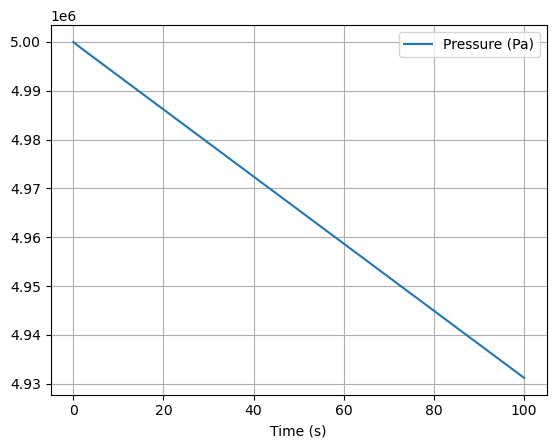

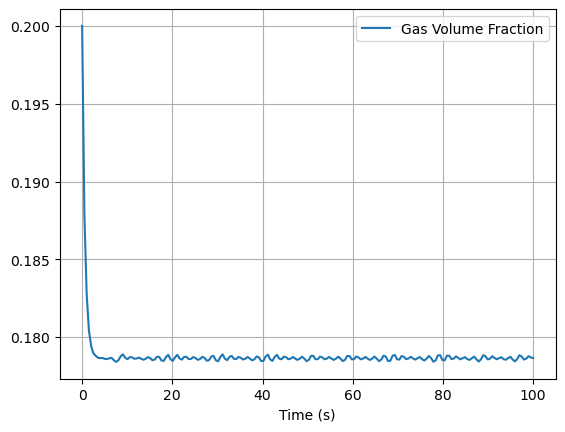

In [11]:
theta_example = prior.sample()
output = multiphase_tank(theta_example).flatten()
P, alpha = output[:200], output[200:]

import matplotlib.pyplot as plt
t = np.linspace(0, 100, 200)

plt.plot(t, P, label="Pressure (Pa)")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(t, alpha, label="Gas Volume Fraction")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
prior, num_parameters, prior_returns_numpy = process_prior(prior)

simulator_wrapper = process_simulator(
    multiphase_tank_summary,
    prior,
    prior_returns_numpy
)

check_sbi_inputs(simulator_wrapper, prior)


In [13]:
# Using simulator_wrapper and prior defined above
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
inference = NPE(prior=prior)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 177 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

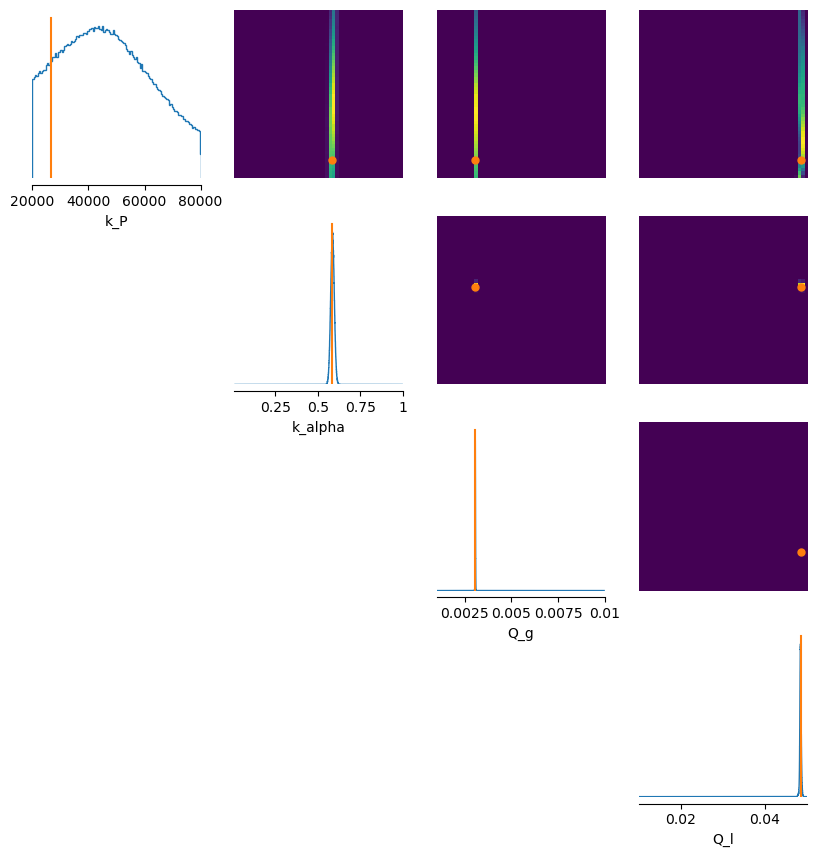

In [14]:
# Synthetic observation
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [15]:
# Define density estimator using the embedding net
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

In [16]:
simulator_wrapper = process_simulator(
    multiphase_tank,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 78 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

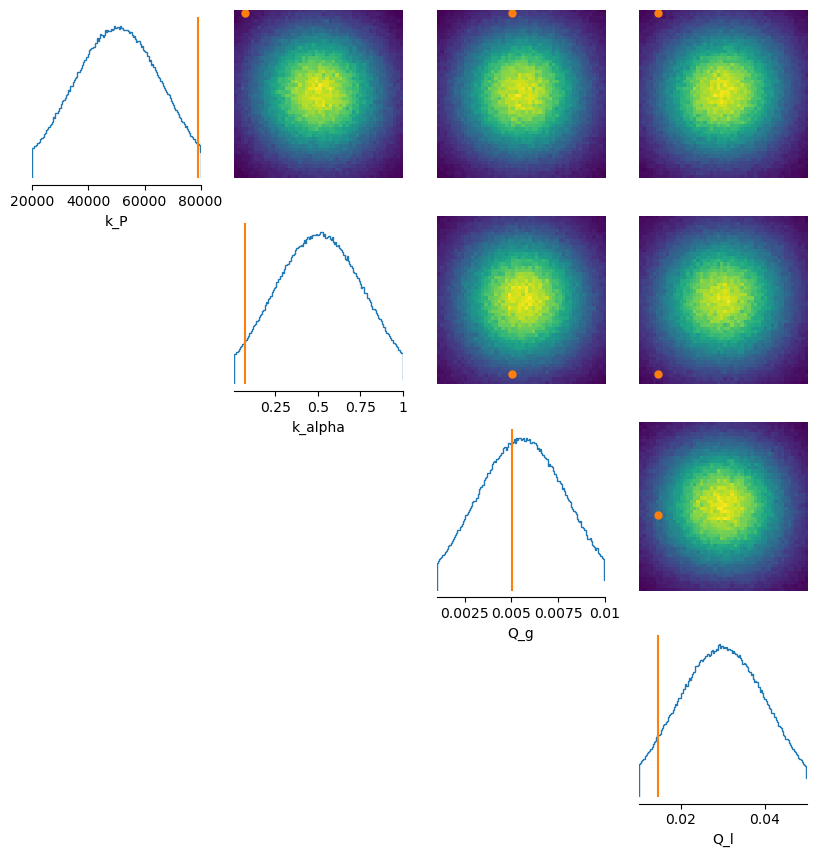

In [17]:
# Synthetic observation
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [18]:
# Define density estimator using the embedding net
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net_large)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_for_cnn,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 62 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

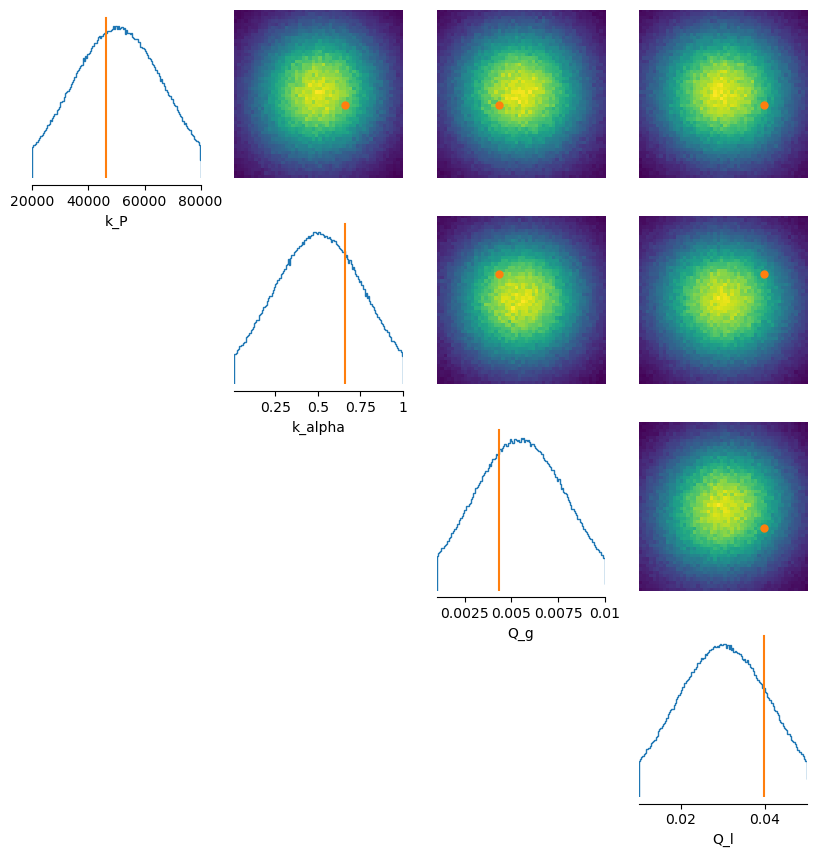

In [19]:
# Synthetic observation
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [20]:
# Define density estimator using the embedding net
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net_large)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_normalized,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 46 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

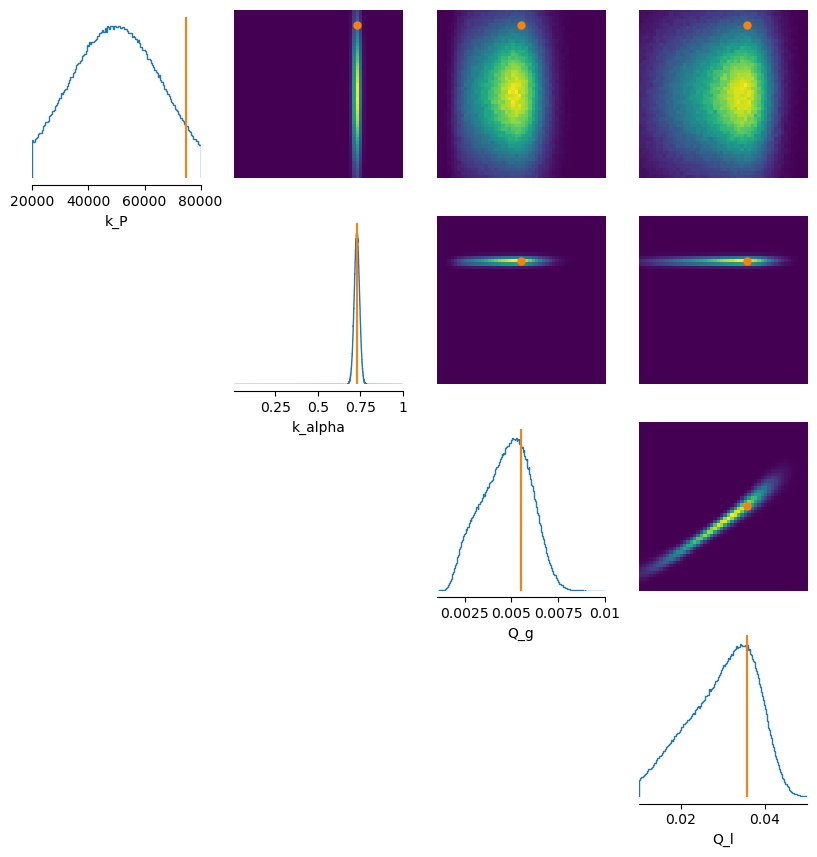

In [21]:
# Synthetic observation
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

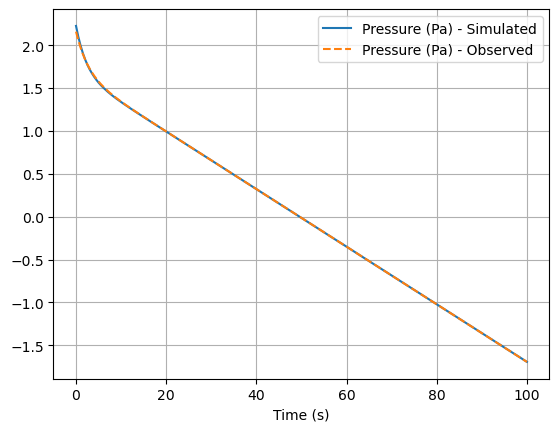

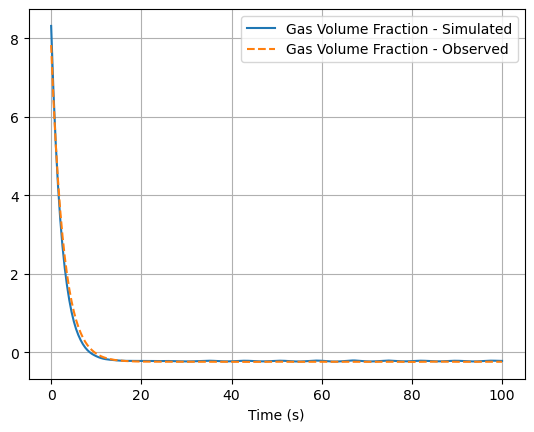

In [22]:
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

posterior_samples = posterior.sample((1,), x=x_o)
theta_example = posterior_samples

output = simulator_wrapper(theta_example).flatten()


P, alpha = output[:200], output[200:]
P_t, alpha_t = x_o.flatten()[:200],  x_o.flatten()[200:]

import matplotlib.pyplot as plt
t = np.linspace(0, 100, 200)

plt.plot(t, P, label="Pressure (Pa) - Simulated")
plt.plot(t, P_t, label="Pressure (Pa) - Observed", linestyle="--")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(t, alpha, label="Gas Volume Fraction - Simulated")
plt.plot(t, alpha_t, label="Gas Volume Fraction - Observed", linestyle="--")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Calculate the standard deviation of posterior_samples along axis 0
posterior_std = posterior_samples.std(dim=0)

result = {label: f"{value:.4f} ± {std:.4f}" for label, value, std in zip(param_labels, posterior_samples[0].tolist(), posterior_std.tolist())}
pprint.pprint(result)


{'Q_g': '0.0054 ± nan',
 'Q_l': '0.0398 ± nan',
 'k_P': '41875.3125 ± nan',
 'k_alpha': '0.2122 ± nan'}


/tmp/ipykernel_14117/2574741339.py:2: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  posterior_std = posterior_samples.std(dim=0)


In [24]:
# Define density estimator using the embedding net for single channel alpha only
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net_single)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_alpha_only,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 65 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

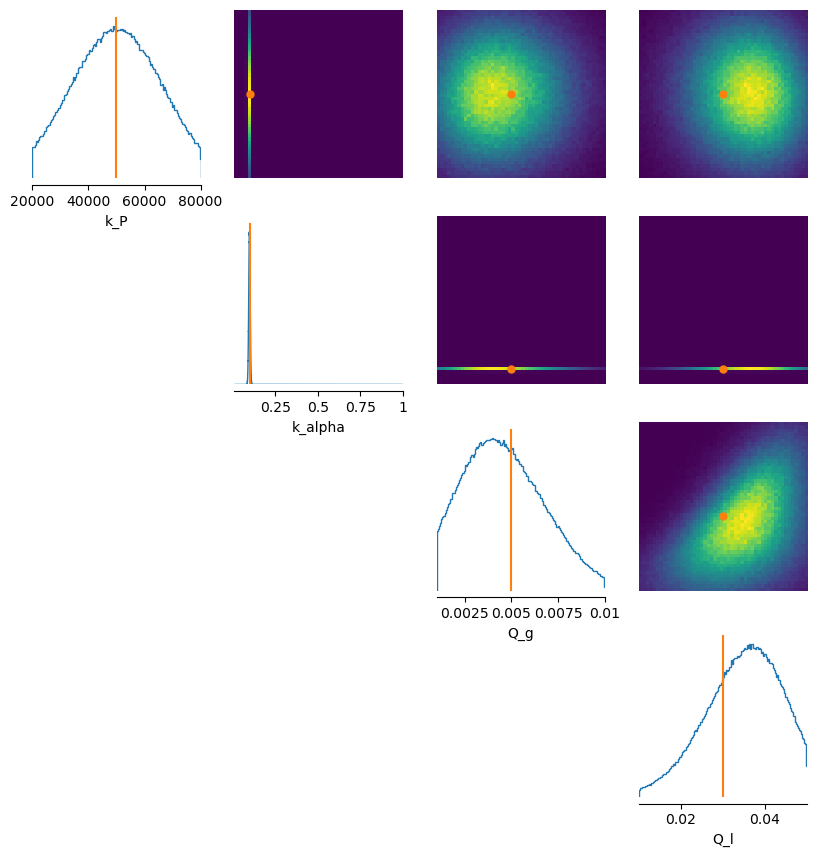

In [25]:
# Synthetic observation for known theta
true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
# true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

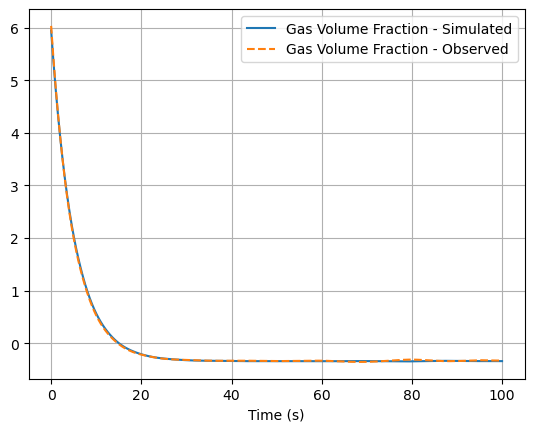

In [26]:
theta_example = posterior.sample((1,), x=x_o)

output = simulator_wrapper(theta_example).flatten()


P, alpha = output[:200], output[200:]
P_t, alpha_t = x_o.flatten()[:200],  x_o.flatten()[200:]


import matplotlib.pyplot as plt
t = np.linspace(0, 100, 200)

plt.plot(t, P, label="Gas Volume Fraction - Simulated")
plt.plot(t, P_t, label="Gas Volume Fraction - Observed", linestyle="--")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Calculate the standard deviation of posterior_samples along axis 0
posterior_std = posterior_samples.std(dim=0)

result = {label: f"{value:.4f} ± {std:.4f}" for label, value, std in zip(param_labels, posterior_samples[0].tolist(), posterior_std.tolist())}
pprint.pprint(result)


{'Q_g': '0.0043 ± 0.0020',
 'Q_l': '0.0230 ± 0.0085',
 'k_P': '59661.0195 ± 13923.8955',
 'k_alpha': '0.0978 ± 0.0043'}


In [28]:
# Define density estimator using the embedding net for single channel alpha only
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net_single)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_pressure_only,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 102 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

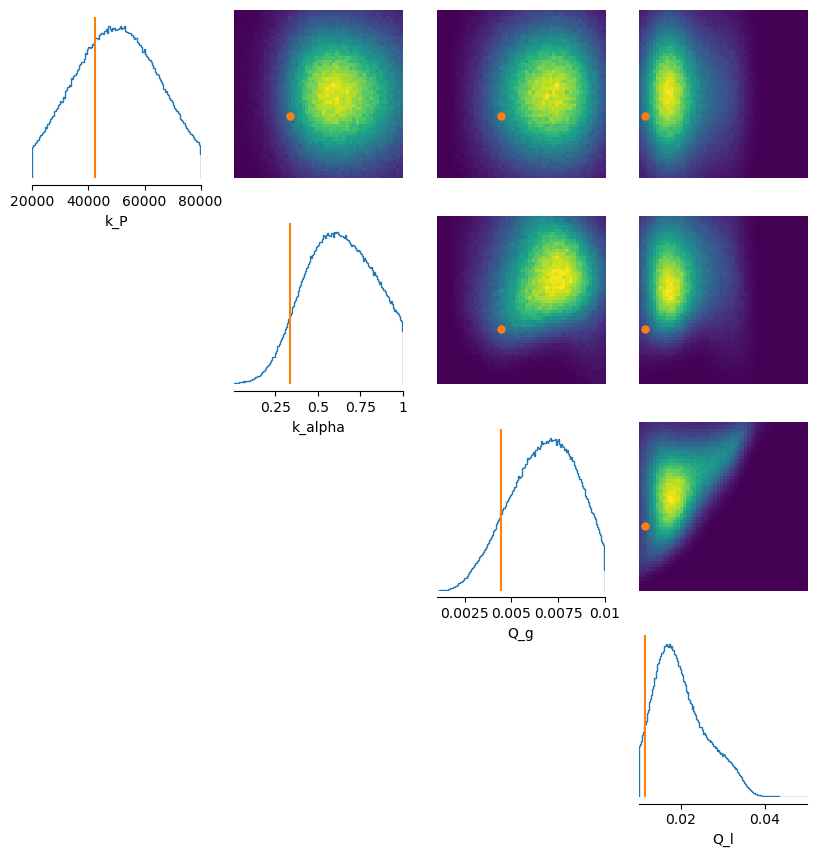

In [29]:
# Synthetic observation for known theta
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

Drawing 1 posterior samples:   0%|          | 0/1 [00:00<?, ?it/s]

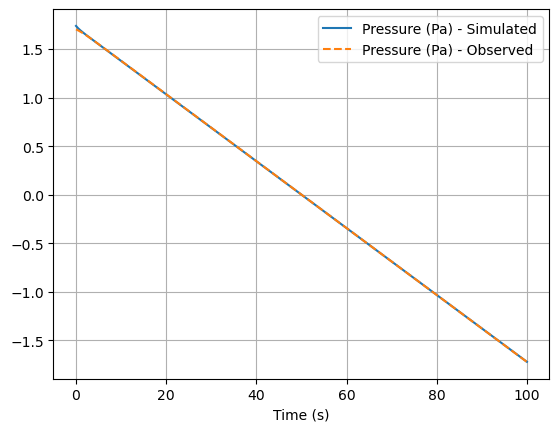

In [30]:

theta_example = posterior.sample((1,), x=x_o)

output = simulator_wrapper(theta_example).flatten()


P, alpha = output[:200], output[200:]
P_t, alpha_t = x_o.flatten()[:200],  x_o.flatten()[200:]


import matplotlib.pyplot as plt
t = np.linspace(0, 100, 200)

plt.plot(t, P, label="Pressure (Pa) - Simulated")
plt.plot(t, P_t, label="Pressure (Pa) - Observed", linestyle="--")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
# Calculate the standard deviation of posterior_samples along axis 0
posterior_std = posterior_samples.std(dim=0)

result = {label: f"{value:.4f} ± {std:.4f}" for label, value, std in zip(param_labels, posterior_samples[0].tolist(), posterior_std.tolist())}
pprint.pprint(result)

{'Q_g': '0.0090 ± 0.0017',
 'Q_l': '0.0248 ± 0.0061',
 'k_P': '51477.6328 ± 13993.9199',
 'k_alpha': '0.4498 ± 0.1970'}


In [32]:
class LSTMEmbedding(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, output_size=10, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,  # 2 = pressure + alpha
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.output_net = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, output_size)
        )

    def forward(self, x):
        # x shape: [batch_size, channels, time]
        x = x.permute(0, 2, 1)  # -> [batch_size, time, channels]
        _, (hn, _) = self.lstm(x)  # hn shape: [num_layers, batch, hidden]
        embedding = hn[-1]  # take last layer's hidden state
        return self.output_net(embedding)

In [33]:
embedding_net = LSTMEmbedding()

# Define density estimator using the embedding net for single channel alpha only
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_normalized,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 191 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

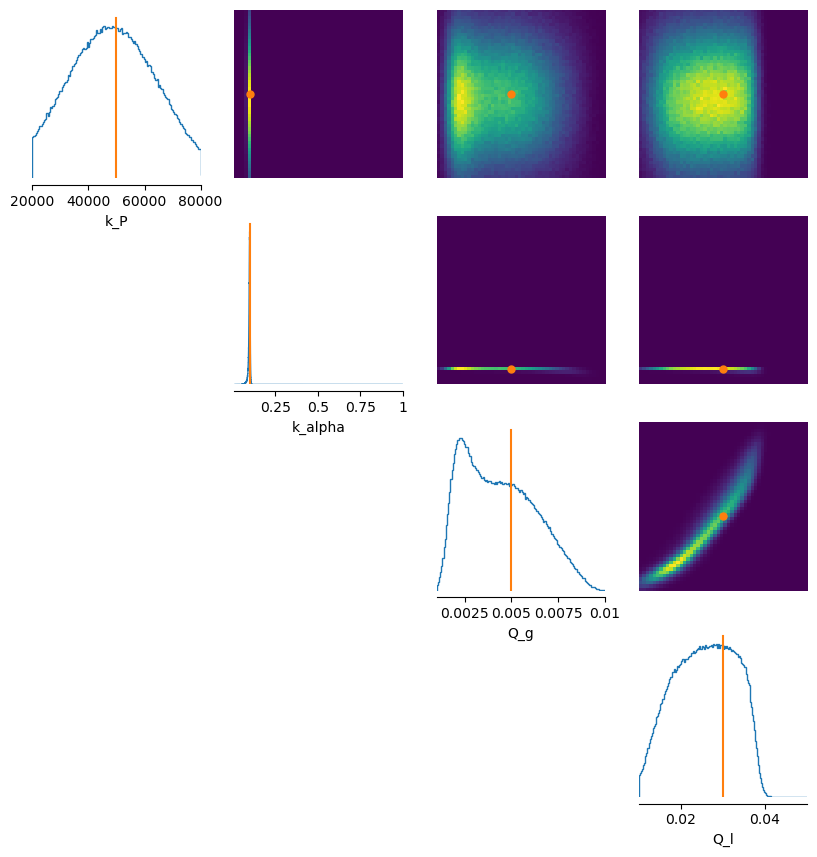

In [34]:
# Synthetic observation for known theta
true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
# true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [35]:
# Calculate the standard deviation of posterior_samples along axis 0
posterior_std = posterior_samples.std(dim=0)

result = {label: f"{value:.4f} ± {std:.4f}" for label, value, std in zip(param_labels, posterior_samples[0].tolist(), posterior_std.tolist())}
pprint.pprint(result)

{'Q_g': '0.0062 ± 0.0019',
 'Q_l': '0.0340 ± 0.0071',
 'k_P': '63542.5625 ± 14082.1787',
 'k_alpha': '0.0985 ± 0.0065'}


In [36]:
embedding_net = GRUEmbedding()

# Define density estimator using the embedding net for single channel alpha only
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_normalized,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 178 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

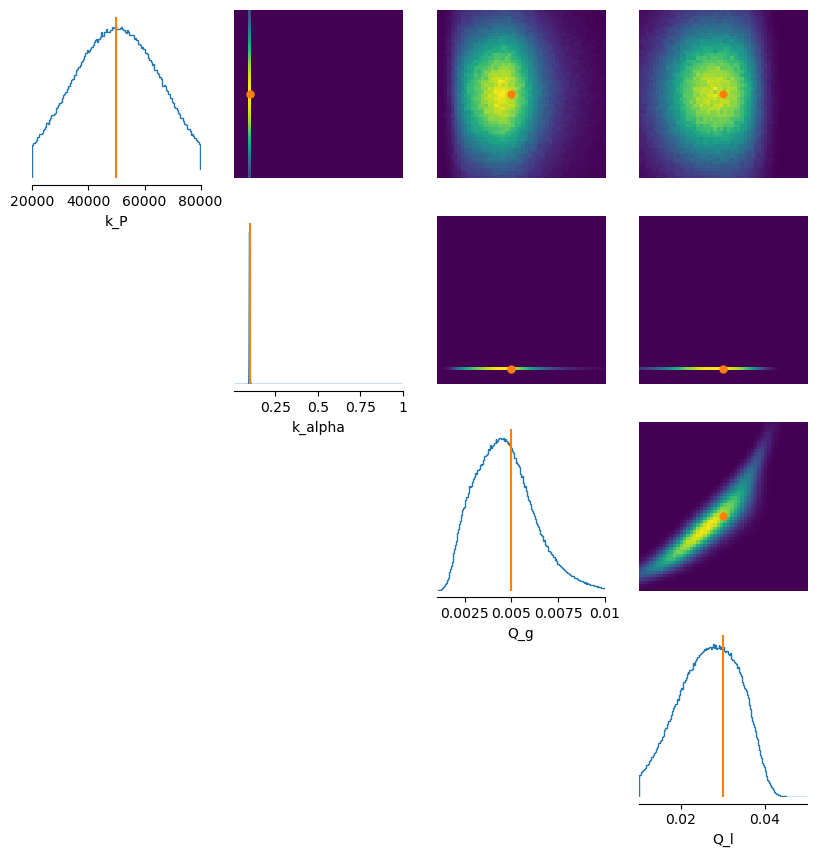

In [37]:
# Synthetic observation for known theta
true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
# true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [38]:
# embedding_net = TransformerEmbedding()

# # Define density estimator using the embedding net for single channel alpha only
# density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
# inference = NPE(prior=prior, density_estimator=density_estimator)

# simulator_wrapper = process_simulator(
#     multiphase_tank_normalized,
#     prior,
#     prior_returns_numpy
# )

# theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=20000)
# _ = inference.append_simulations(theta, x).train()
# posterior = inference.build_posterior()

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

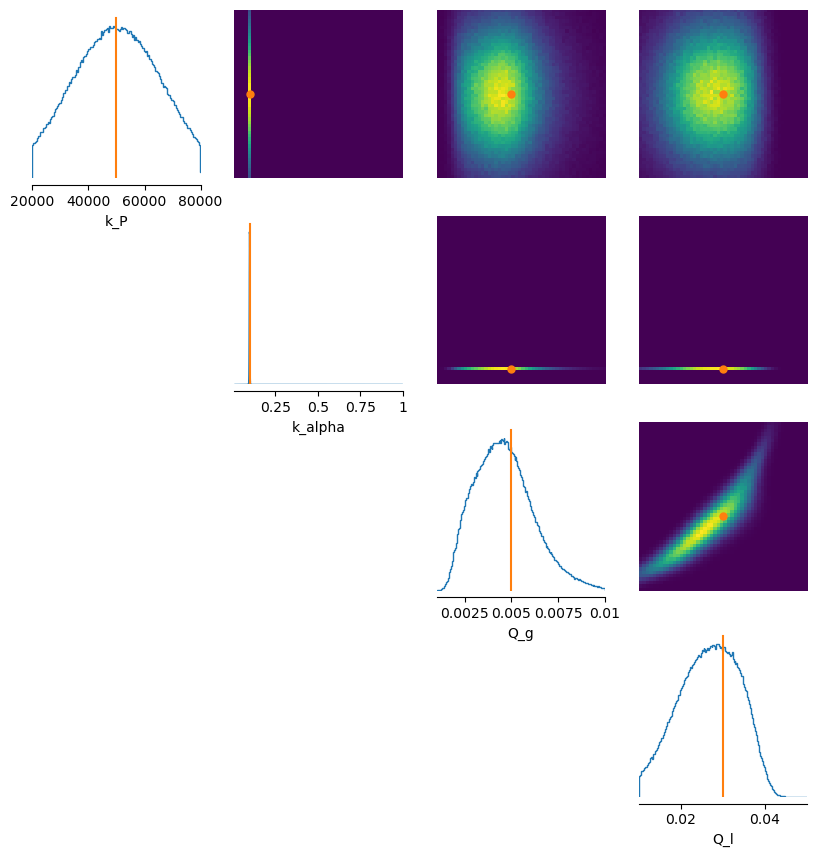

In [39]:
# Synthetic observation for known theta
true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
# true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [40]:
sequence_net = LSTMEmbedding()
embedding_net = HybridEmbedding(seq_embed_net=sequence_net)

# Define density estimator using the embedding net for single channel alpha only
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_hybrid,
    prior,
    prior_returns_numpy
)

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 145 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

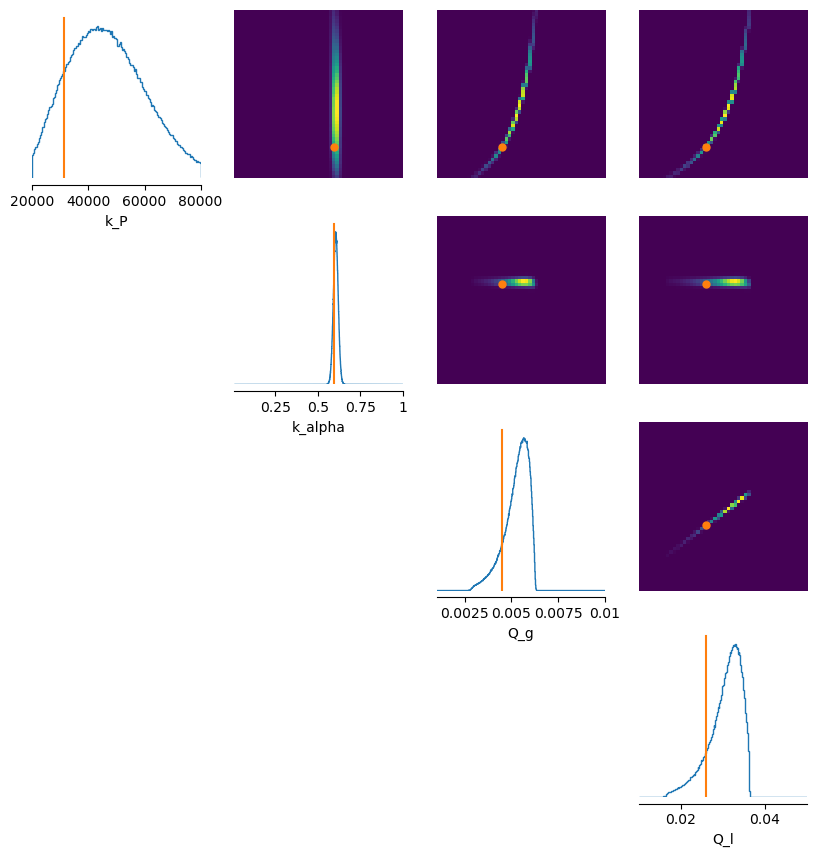

In [41]:
# Synthetic observation for known theta
# true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [42]:
# Calculate the standard deviation of posterior_samples along axis 0
posterior_std = posterior_samples.std(dim=0)

result = {label: f"{value:.4f} ± {std:.4f}" for label, value, std in zip(param_labels, posterior_samples[0].tolist(), posterior_std.tolist())}
pprint.pprint(result)

{'Q_g': '0.0058 ± 0.0007',
 'Q_l': '0.0334 ± 0.0039',
 'k_P': '56316.4570 ± 13182.8643',
 'k_alpha': '0.6170 ± 0.0140'}


In [43]:
sequence_net = LSTMEmbedding()
embedding_net = HybridEmbedding(seq_embed_net=sequence_net)

density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

# Before training
stats_list = []
for _ in range(1000):  # Or match num_simulations
    theta_i = prior.sample()
    stats_i = multiphase_tank_summary(theta_i.numpy())
    stats_list.append(stats_i)

stats_array = np.stack(stats_list)
stats_mean = stats_array.mean(axis=0)
stats_std = stats_array.std(axis=0) + 1e-8  # avoid div by 0

simulator_wrapper = process_simulator(
    multiphase_tank_hybrid_normalized,
    prior,
    prior_returns_numpy
)


theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=20000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/20000 [00:00<?, ?it/s]

 Neural network successfully converged after 162 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

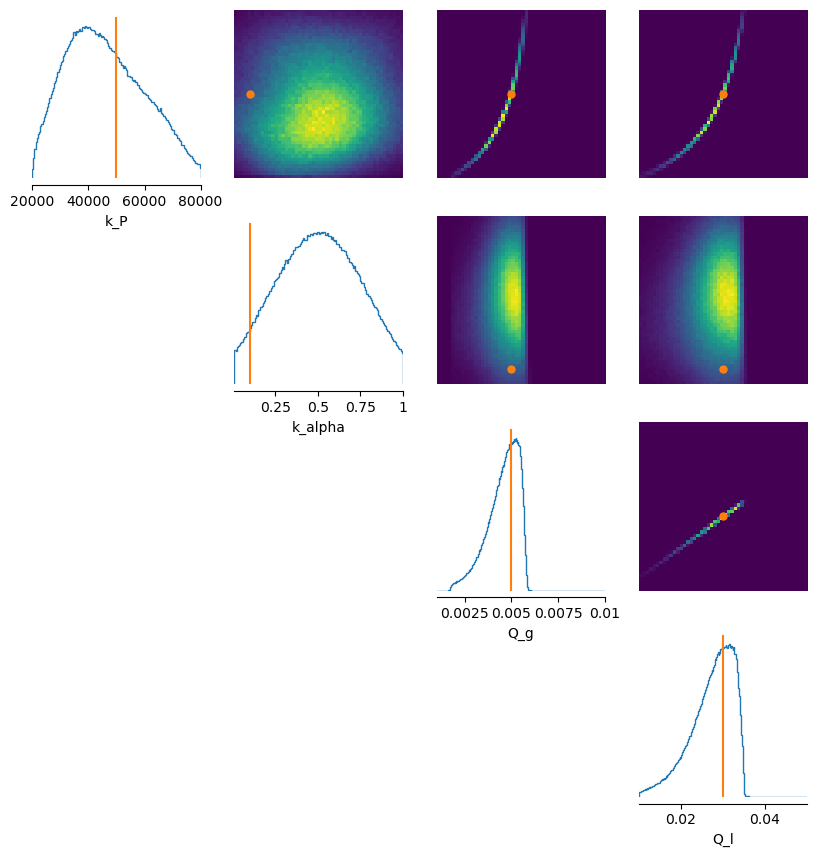

In [44]:
# Synthetic observation for known theta
true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
# true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [45]:
sequence_net = LSTMEmbedding()
embedding_net = HybridEmbedding(seq_embed_net=sequence_net)

# Define density estimator using the embedding net for single channel alpha only
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

simulator_wrapper = process_simulator(
    multiphase_tank_hybrid,
    prior,
    prior_returns_numpy
)


theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=1000)
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 197 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

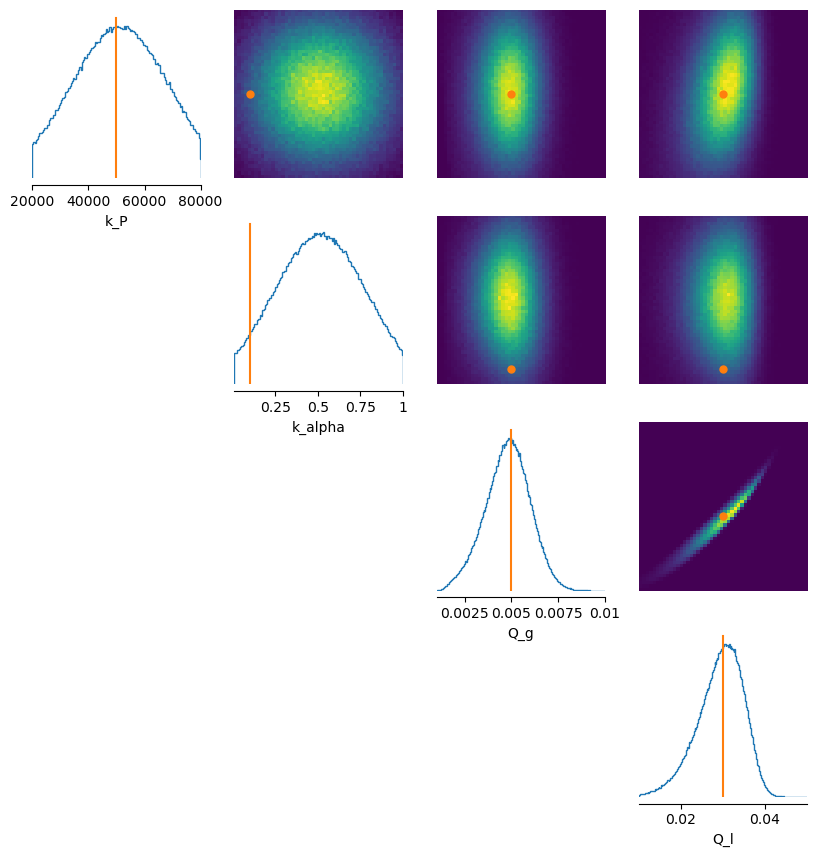

In [46]:

# Synthetic observation for known theta
true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
# true_theta = np.array([prior.sample()])
x_o = simulator_wrapper(true_theta)

# Sample posterior
posterior_samples = posterior.sample((num_samples,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)

In [47]:
# Calculate the standard deviation of posterior_samples along axis 0
posterior_std = posterior_samples.std(dim=0)

result = {label: f"{value:.4f} ± {std:.4f}" for label, value, std in zip(param_labels, posterior_samples[0].tolist(), posterior_std.tolist())}
pprint.pprint(result)

{'Q_g': '0.0034 ± 0.0012',
 'Q_l': '0.0249 ± 0.0054',
 'k_P': '76083.8438 ± 14266.9619',
 'k_alpha': '0.3581 ± 0.2306'}


In [48]:
# multi-round

# 1. Setup embedding and inference
sequence_net = LSTMEmbedding()
embedding_net = HybridEmbedding(seq_embed_net=sequence_net)
density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

# 2. Precompute normalization stats
stats_list = []
for _ in range(500):  # Smaller number is fine for estimating stats
    theta_i = prior.sample()
    stats_i = multiphase_tank_summary(theta_i.numpy())
    stats_list.append(stats_i)
stats_array = np.stack(stats_list)
stats_mean = stats_array.mean(axis=0)
stats_std = stats_array.std(axis=0) + 1e-8

# 3. Wrap simulator
simulator_wrapper = process_simulator(
    multiphase_tank_hybrid,  # this should return {"sequence": ..., "stats": ...}
    prior,
    prior_returns_numpy
)

# 4. Define true observation
true_theta = torch.tensor([[5e4, 0.1, 0.005, 0.03]])
x_o = simulator_wrapper(true_theta)  # dict → properly handled by sbi if using custom embedder


# 5. Multi-round inference loop
posterior = None

for r in range(num_rounds):
    print(f"\nRound {r+1}...")

    # Use posterior from previous round as proposal
    proposal = posterior.set_default_x(x_o) if posterior is not None else prior

    # Simulate using current proposal
    theta, x = simulate_for_sbi(simulator_wrapper, proposal, num_simulations=5000)

    # Train and build posterior
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)


Round 1...


  0%|          | 0/5000 [00:00<?, ?it/s]

 Neural network successfully converged after 142 epochs.
Round 2...


Drawing 5000 posterior samples:   0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 92 epochs.

Drawing 1000000 posterior samples:   0%|          | 0/1000000 [00:00<?, ?it/s]

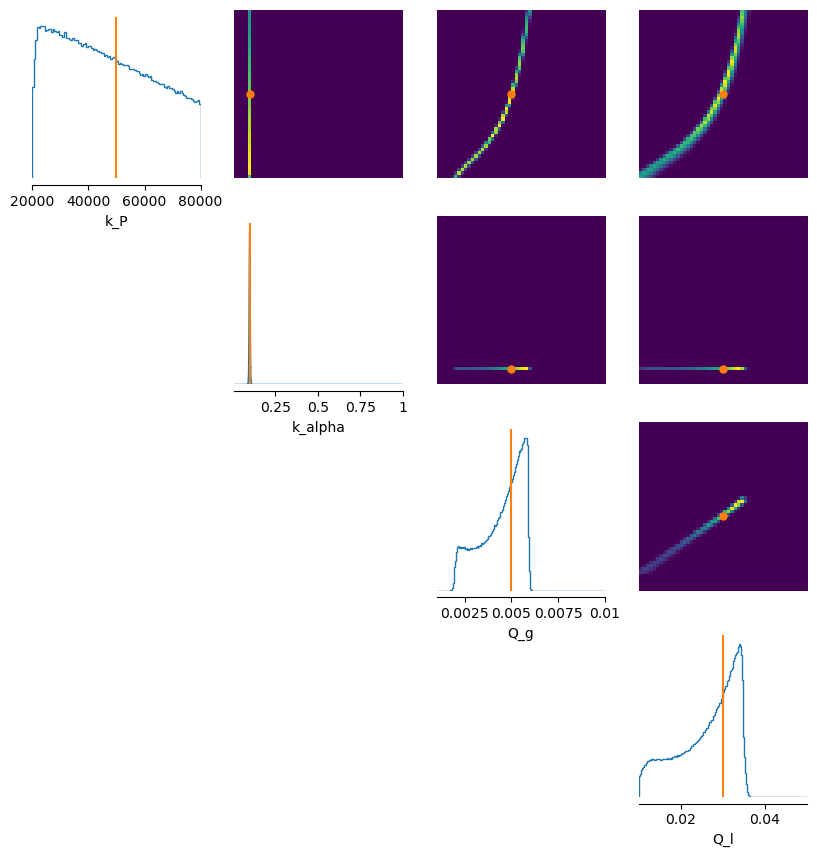

In [49]:
# Sample posterior
posterior_samples = posterior.sample((1000000,), x=x_o)

param_labels = ['k_P', 'k_alpha', 'Q_g', 'Q_l']
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

fig, ax = pairplot(
    posterior_samples,
    points=true_theta,
    labels=param_labels,
    limits=limits
)